***
# Load Data :

In [1]:
# Ground modules
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from itertools import product
import random
from collections import Counter
import warnings
import logging
import subprocess
from multiprocessing.pool import ThreadPool

# SCikitlearn modules :
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report , roc_auc_score

# Scipy modules : 
from scipy.stats import fisher_exact

In [11]:
# *****************************************************************************
# Load the Dataframes :
#path_work = "/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Seqbased_model"
path_work = "/media/concha-eloko/Linux/PPT_clean"

DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df.tsv", sep = "\t" ,  header = 0)
DF_info_lvl_0 = DF_info[~DF_info["KL_type_LCA"].str.contains("\\|")]
DF_info_lvl_0 = DF_info_lvl_0.drop_duplicates(subset = ["Infected_ancestor","index","prophage_id"] , keep = "first").reset_index(drop=True)

# useful dictionary :
dico_prophage_kltype_associated = {}
for negative_index,phage in tqdm(enumerate(DF_info_lvl_0["Phage"].unique().tolist())) :
    kltypes = set()
    dpos = DF_info_lvl_0[DF_info_lvl_0["Phage"] == phage]["index"]
    for dpo in dpos : 
        tmp_kltypes = DF_info_lvl_0[DF_info_lvl_0["index"] == dpo]["KL_type_LCA"].values
        kltypes.update(tmp_kltypes)
    dico_prophage_kltype_associated[phage] = kltypes


8815it [00:19, 453.37it/s]


> Get the weighted MCC

In [5]:
path_metrics = "/media/concha-eloko/Linux/PPT_clean/RF_1912_models_info"

header_metric = ["KL_type", "Effectifs","MCC","F1","recall","Accuracy","AUC"]
dico_metrics = {}

for file in os.listdir(path_metrics) :
    tmp_dico = {}
    threshold = float(file.split("report.")[1].split(".1912")[0])
    df_metric = pd.read_csv(f"{path_metrics}/{file}" , sep = "\t", names = header_metric).fillna("NaN")
    for _,row in df_metric.iterrows() :
        if row["MCC"] != '***No sufficient Data':
            tmp_dico[row["KL_type"]] = float(row["MCC"])
    dico_metrics[f"{threshold}"] = tmp_dico
                

    

In [6]:
df = pd.DataFrame.from_dict(dico_metrics, orient='index')

In [7]:
df

,KL43,KL14,KL107,KL106,KL23,KL51,KL63,KL30,KL64,KL47,...,KL56,KL71,KL124,KL162,KL141,KL157,KL146,KL42,KL143,KL104
0.85,0.451015,0.921512,0.824190,0.744787,0.893869,0.641886,0.858636,0.583713,0.777660,0.719540,...,1.000000,0.546119,0.790569,0.0,0.0,0.438529,0.000000,-0.13484,1.000000,1.0
0.75,0.602208,0.869279,0.823429,0.720188,0.749848,0.514828,0.858636,0.619547,0.785788,0.723745,...,1.000000,0.793492,0.790569,0.0,0.0,0.300000,0.654654,0.00000,1.000000,1.0
0.975,0.370711,0.894691,0.808644,0.785000,0.655495,0.818062,0.608409,0.583803,0.821295,0.783433,...,0.000000,0.000000,0.790569,0.0,0.0,0.000000,0.654654,0.00000,1.000000,1.0
0.7,0.366217,0.921512,0.821017,0.763192,0.689328,0.778212,0.861289,0.582061,0.799392,0.741071,...,0.832050,1.000000,0.600000,0.0,0.0,0.645497,0.654654,-0.13484,1.000000,1.0
0.8,0.533712,0.894531,0.808064,0.768659,0.752037,0.641886,0.749232,0.619547,0.779676,0.767194,...,1.000000,0.793492,0.600000,0.0,0.0,0.645497,0.000000,0.00000,0.848528,1.0
0.65,0.602208,0.921512,0.797711,0.794155,0.689328,0.732886,0.895979,0.553285,0.752516,0.710767,...,1.000000,1.000000,0.790569,0.0,0.0,0.645497,0.000000,0.00000,1.000000,1.0
0.95,0.148630,0.921512,0.801288,0.816236,0.657003,0.733803,0.683740,0.647796,0.792006,0.773925,...,0.786796,0.000000,0.600000,0.0,0.0,0.438529,0.000000,0.00000,0.000000,1.0
0.9,0.458063,0.921512,0.806860,0.721629,0.556575,0.675129,0.858636,0.590493,0.817245,0.739458,...,1.000000,0.000000,0.542326,0.0,0.0,0.438529,0.000000,0.00000,1.000000,1.0


***
## Calculate the weigthed MCC

In [12]:
df_prophage = DF_info_lvl_0.drop_duplicates(subset = ["Phage"], keep = "first")
count_KLtypes = dict(Counter(df_prophage["KL_type_LCA"]))

total_count = 8815

In [33]:
df

,KL43,KL14,KL107,KL106,KL23,KL51,KL63,KL30,KL64,KL47,...,KL152,KL117,KL4,KL56,KL71,KL124,KL141,KL157,KL42,KL143
0.95,0.458063,0.921512,0.830760,0.797680,0.602872,0.658052,0.683740,0.697745,0.814842,0.759080,...,0.6742,-0.118345,0.645497,1.000000,0.000000,0.600000,0.0,0.000000,0.00000,1.0
0.7,0.451015,0.894531,0.806860,0.746999,0.689328,0.693216,0.683740,0.696729,0.762886,0.726735,...,0.4000,0.402374,0.645497,1.000000,0.607843,0.600000,0.0,0.645497,0.00000,1.0
0.975,0.366217,0.894691,0.814562,0.683813,0.687850,0.842923,0.861289,0.557667,0.818055,0.764802,...,0.6742,0.402374,0.825723,0.537484,0.000000,0.600000,0.0,0.000000,0.00000,1.0
0.9,0.533712,0.894531,0.799978,0.783715,0.721845,0.611961,0.823810,0.640729,0.798064,0.745012,...,0.6742,0.000000,0.000000,1.000000,-0.096374,0.542326,0.0,0.193649,0.00000,1.0
0.75,0.526565,0.921512,0.805723,0.735984,0.865854,0.712424,0.895979,0.670271,0.772364,0.715384,...,0.0000,0.000000,0.825723,0.832050,0.793492,0.790569,0.0,0.645497,0.00000,1.0
0.85,0.465685,0.894531,0.836644,0.767157,0.719259,0.712424,0.895979,0.553245,0.813182,0.740923,...,0.6742,0.205798,0.825723,1.000000,0.000000,0.790569,0.0,0.438529,-0.13484,1.0
0.8,0.526565,0.894531,0.806860,0.720216,0.721845,0.675129,0.786348,0.583713,0.769147,0.753425,...,0.6742,0.000000,0.825723,1.000000,1.000000,0.600000,0.0,0.645497,0.00000,1.0
0.65,0.465685,0.869279,0.840760,0.775707,0.781515,0.712424,0.895979,0.580573,0.779591,0.732324,...,0.6742,0.402374,0.650000,1.000000,0.546119,0.542326,0.0,0.440386,-0.13484,1.0


In [13]:
MCC_weighted = {}
KLtypes = df.columns

for threshold,row in df.iterrows() :
    MCC_value = 0 
    for kltype in KLtypes : 
        weighted_mcc = row[kltype] * count_KLtypes[kltype]
        MCC_value += weighted_mcc
    MCC_weighted[threshold] = MCC_value / total_count

MCC_weighted

{'0.85': 0.7408451765939608,
 '0.75': 0.732142488162259,
 '0.975': 0.7362389084254318,
 '0.7': 0.7514114276446685,
 '0.8': 0.7521222617549144,
 '0.65': 0.7494243916350645,
 '0.95': 0.7400558066795087,
 '0.9': 0.7385386364764064}

***
## Make figures :

> Plot the MCC values :

/tmp/ipykernel_2649927/2094339931.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Column', y='Value', hue='index', data=df_melted, ci=None)


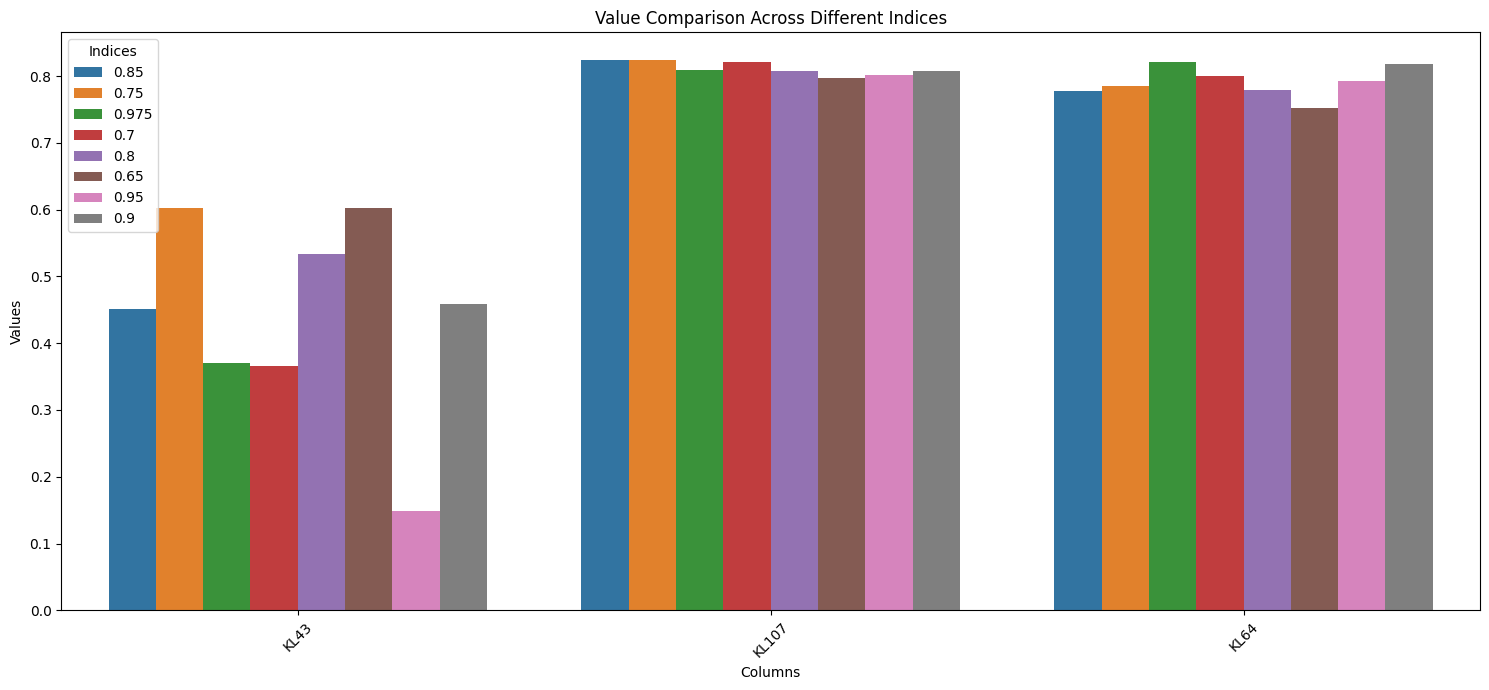

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your dataframe

# Melting the DataFrame to have a long-form DataFrame
df_melted = df.reset_index().melt(id_vars='index', var_name='Column', value_name='Value')

# You can filter out the columns you want to plot; if you want to plot all columns, skip this step
columns_to_plot = ['KL43', 'KL64', 'KL107']  # Customize this list as per your preference
df_melted = df_melted[df_melted['Column'].isin(columns_to_plot)]

# Creating the bar plot
plt.figure(figsize=(15, 7))
sns.barplot(x='Column', y='Value', hue='index', data=df_melted, ci=None)

plt.title("Value Comparison Across Different Indices")
plt.xlabel("Columns")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.legend(title="Indices")
plt.tight_layout()
plt.show()

***
### Best predictive model at 0.80

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/prediction_depolymerase_tropism/prophage_prediction/depolymerase_decipher/ficheros_28032023/Seqbased_model/selected_RF_1912 \
/media/concha-eloko/Linux/PPT_clean/  

In [ ]:
../selected_RF_1912/

In [1]:
import pandas as pd 
import os 

path_seqbased = "/media/concha-eloko/Linux/PPT_clean/Seqbased_model"

seqbased_df = pd.read_csv(f"{path_seqbased}/RF_report.0.85.deep.no_collapse.long.slow.0711.pkl.tsv", sep = "\t", names = ["KL_type", "Effectifs","MCC","F1","Accuracy"])

In [7]:
df_metrics_sorted = seqbased_df.sort_values(by='KL_type', key=lambda x: x.str.split("KL").str[1].astype(int))
for col in df_metrics_sorted.columns : 
    if col not in ["KL_type","n_prophages"] : 
        df_metrics_sorted[col] = round(df_metrics_sorted[col] , 4)

df_metrics_sorted.to_csv(f"{path_seqbased}/Metric_Report.seqbased.1911.clean.tsv", sep = "\t", index = False, )